## Transcription Comparison Tool

Explanation
Reading CSV Files:

The read_csv_files function recursively reads all CSV files in the specified directory and subdirectories.
Each CSV file is read into a separate DataFrame, and the source file path is stored in a new column.
Processing Transcriptions:

Each DataFrame is processed individually to clean the text, tokenize, and perform POS tagging and NER.
This keeps the analyses of each transcription separate.
Generating Embeddings and Calculating Similarity:

Embeddings are generated for the entire cleaned transcript text of each file.
The embeddings are stored in a list along with the corresponding file names.
The cosine similarity matrix is computed to compare each transcription against all others.
Topic Modeling with LDA:

LDA is performed on the tokens of each transcription separately.
The topics for each transcription are printed out, allowing you to compare the topics between different transcriptions.


pip install pandas numpy nltk spacy sentence-transformers scikit-learn
python -m spacy download en_core_web_sm


c:\Users\mrhal\anaconda3\envs\NLTKpipeline-env\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\mrhal\anaconda3\envs\NLTKpipeline-env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers

                                                    data/rawTranscriptFiles/interview_transcripts\20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv  \
data/rawTranscriptFiles/interview_transcripts\2...                                           1.000000                                                       
data/rawTranscriptFiles/interview_transcripts\2...                                           0.652872                                                       
data/rawTranscriptFiles/interview_transcripts\2...                                           0.684145                                                       
data/rawTranscriptFiles/interview_transcripts\2...                                           0.604974                                                       
data/rawTranscriptFiles/interview_transcripts\2...                                           0.557976                                                       
data/rawTranscriptFiles/interview_transcripts\2...        

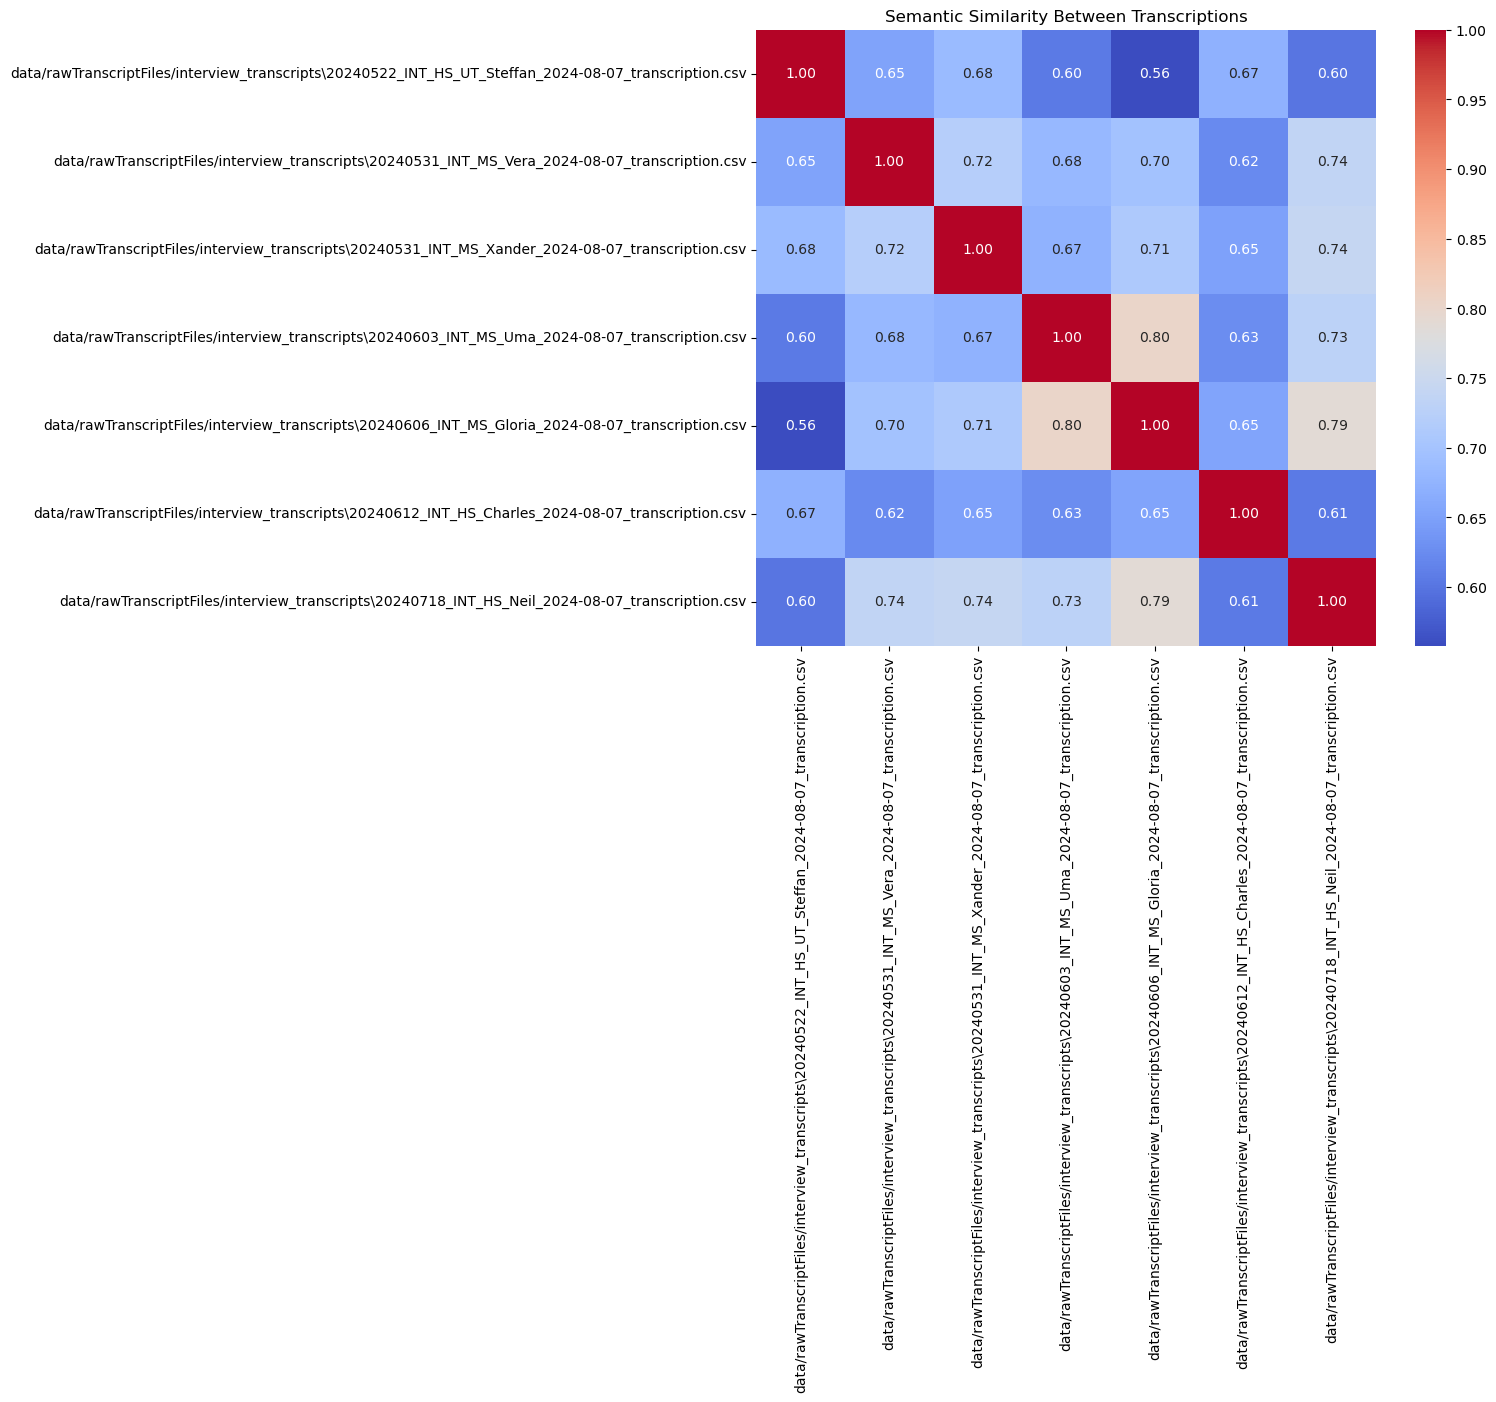

Topics for data/rawTranscriptFiles/interview_transcripts\20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv:
(0, '0.036*"like" + 0.035*"right" + 0.026*"know" + 0.017*"think" + 0.015*"going"')
(1, '0.035*"like" + 0.017*"classroom" + 0.017*"think" + 0.015*"really" + 0.012*"lot"')
(2, '0.059*"think" + 0.030*"like" + 0.017*"really" + 0.016*"im" + 0.016*"right"')
(3, '0.083*"like" + 0.035*"know" + 0.018*"right" + 0.017*"students" + 0.016*"dont"')
(4, '0.073*"yeah" + 0.038*"like" + 0.034*"know" + 0.023*"im" + 0.020*"really"')


Topics for data/rawTranscriptFiles/interview_transcripts\20240531_INT_MS_Vera_2024-08-07_transcription.csv:
(0, '0.063*"like" + 0.017*"would" + 0.015*"yeah" + 0.013*"year" + 0.011*"okay"')
(1, '0.066*"yeah" + 0.066*"like" + 0.026*"um" + 0.020*"really" + 0.015*"youre"')
(2, '0.105*"like" + 0.018*"oh" + 0.015*"okay" + 0.013*"kind" + 0.013*"know"')
(3, '0.063*"like" + 0.050*"okay" + 0.020*"know" + 0.014*"science" + 0.014*"theyre"')
(4, '0.083*"like" + 0.048*"know" +

In [1]:
import os
import glob
import pandas as pd
import re
import nltk
import spacy
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Setup
nltk.download('punkt')
nltk.download('stopwords')
file_path = 'data/rawTranscriptFiles/interview_transcripts'
nlp = spacy.load('en_core_web_sm')
stop_words = set(nltk.corpus.stopwords.words('english'))
model = SentenceTransformer('all-MiniLM-L6-v2')

# Functions
def read_csv_files(directory):
    csv_files = glob.glob(os.path.join(directory, '**', '*.csv'), recursive=True)
    data_frames = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['source_file'] = file  # Keep track of the source file
        data_frames.append(df)
    return data_frames

def preprocess_text(text):
    # Lowercase conversion
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def spacy_analysis(text):
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return pos_tags, entities

def perform_lda(tokens_list, num_topics=5):
    dictionary = Dictionary(tokens_list)
    dictionary.filter_extremes(no_below=1, no_above=0.5)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    return lda, corpus, dictionary

# Execution
directory = file_path
transcript_dfs = read_csv_files(directory)

embeddings_list = []
file_names = []
lda_models = []

for df in transcript_dfs:
    df['cleaned_transcript'] = df['text'].apply(preprocess_text)
    df['tokens'] = df['cleaned_transcript'].apply(tokenize_text)
    df[['pos_tags', 'entities']] = df['cleaned_transcript'].apply(
        lambda x: pd.Series(spacy_analysis(x))
    )

    # Generate embeddings
    text = ' '.join(df['cleaned_transcript'])
    embedding = model.encode(text)
    embeddings_list.append(embedding)
    file_names.append(df['source_file'].iloc[0])

    # Perform LDA
    tokens_list = df['tokens'].tolist()
    lda_model, corpus, dictionary = perform_lda(tokens_list)
    lda_models.append({
        'model': lda_model,
        'corpus': corpus,
        'dictionary': dictionary,
        'source_file': df['source_file'].iloc[0]
    })

# Compute similarity matrix
embeddings_array = np.vstack(embeddings_list)
similarity_matrix = cosine_similarity(embeddings_array)
similarity_df = pd.DataFrame(similarity_matrix, index=file_names, columns=file_names)
print(similarity_df)

# Visualize similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Semantic Similarity Between Transcriptions')
plt.show()

# Print topics from LDA models
for lda_info in lda_models:
    print(f"Topics for {lda_info['source_file']}:")
    topics = lda_info['model'].print_topics(num_words=5)
    for topic in topics:
        print(topic)
    print('\n')


# Semantic Similarity Sentence Matcher

c:\Users\mrhal\anaconda3\envs\NLTKpipeline-env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 17/17 [00:02<00:00,  7.71it/s]


Columns in results_df: ['source_file', 'sentence_number', 'text', 'speaker', 'similarity_score', 'key_sentence', 'key_sentence_index']
                                         source_file  sentence_number  \
0  20240522_INT_HS_UT_Steffan_2024-08-07_transcri...                6   
1  20240522_INT_HS_UT_Steffan_2024-08-07_transcri...               27   
2  20240522_INT_HS_UT_Steffan_2024-08-07_transcri...               51   
3  20240522_INT_HS_UT_Steffan_2024-08-07_transcri...              212   
4  20240522_INT_HS_UT_Steffan_2024-08-07_transcri...              274   

                                                text     speaker  \
0                          So what are you teaching?  SPEAKER_01   
1  I think that's my only role outside of the cla...  SPEAKER_00   
2                                     Love teaching.  SPEAKER_00   
3   the needs of a few students who definitely ne...  SPEAKER_00   
4  And then gradually figure out how to take thos...  SPEAKER_00   

   similarity_sco

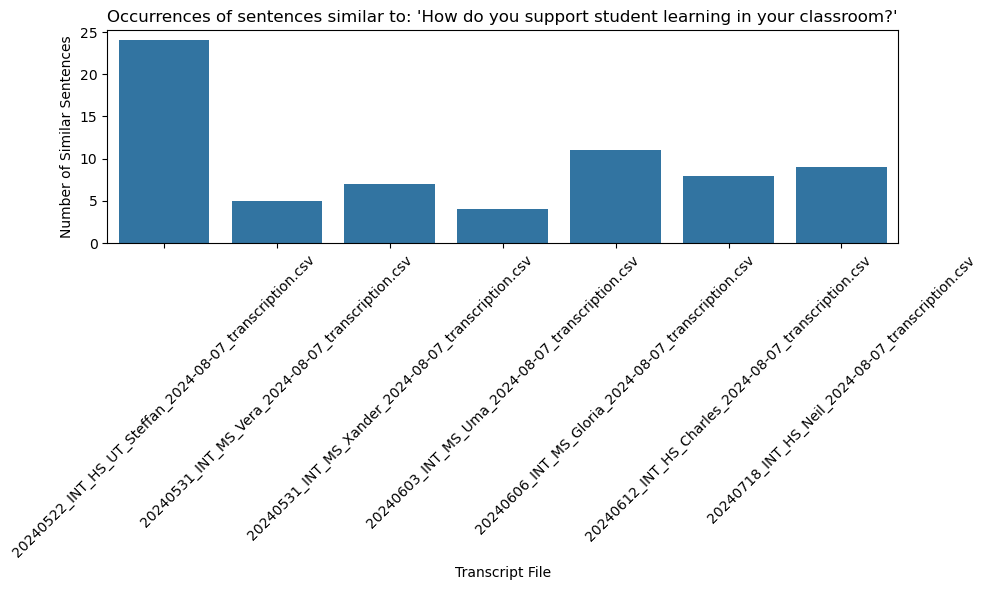

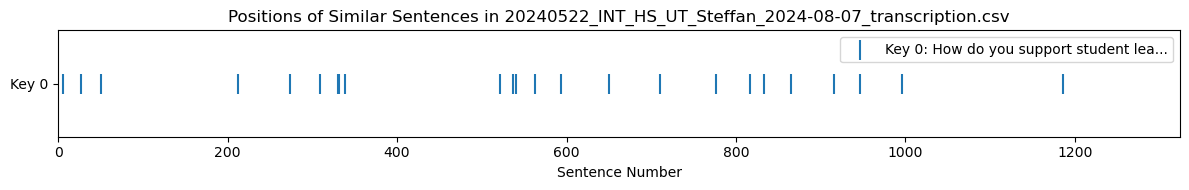

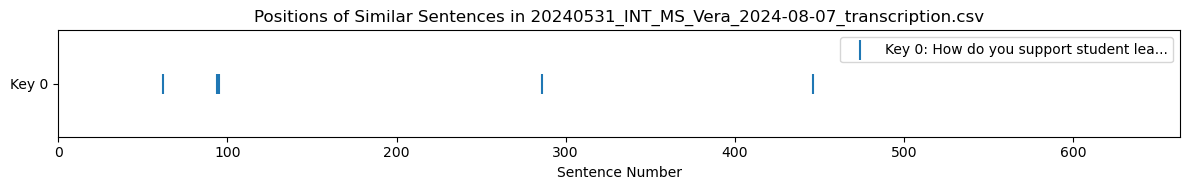

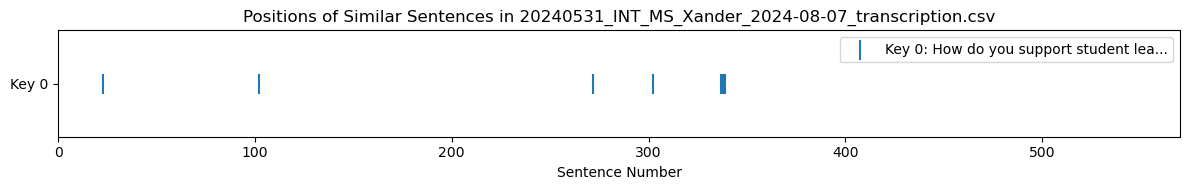

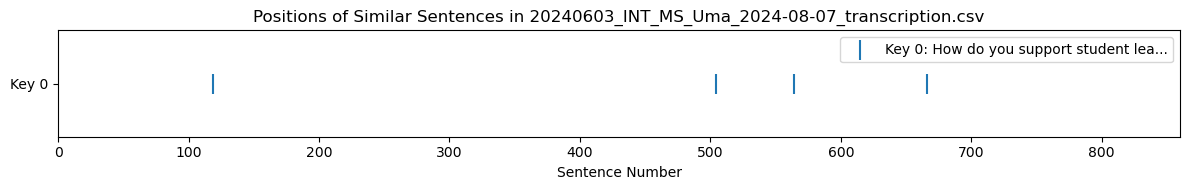

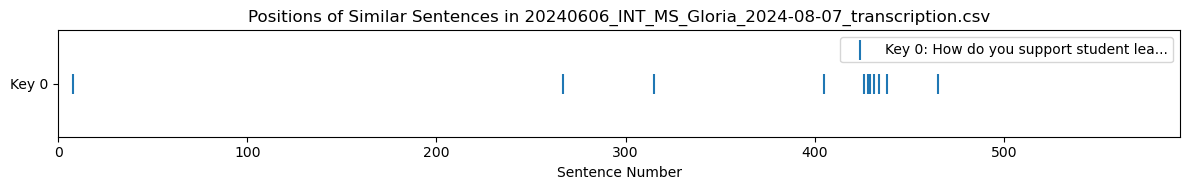

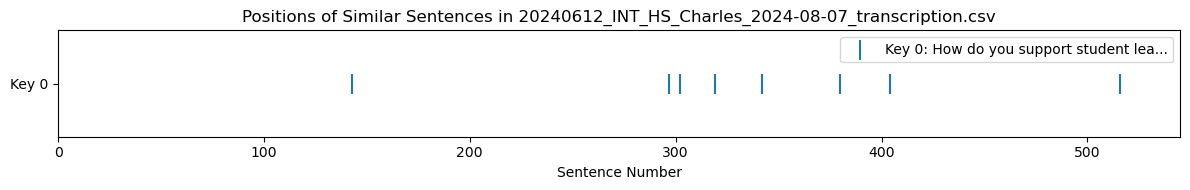

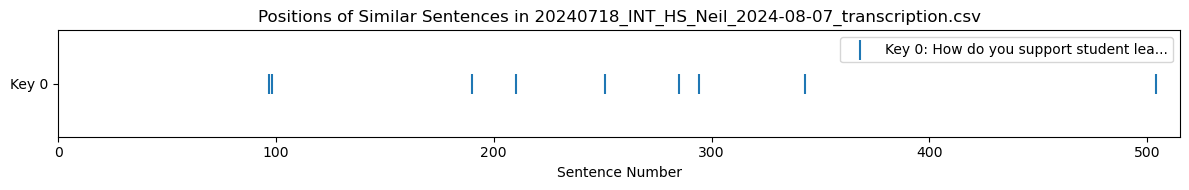

NameError: name 'transcript_html' is not defined

In [6]:
import os
import glob
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm import tqdm  # To track progress
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px

# 1. Define key sentences
key_sentences = [
    "How do you support student learning in your classroom?",
    # Add more key sentences as needed
]


# 2. Generate embeddings for key sentences
model = SentenceTransformer('all-MiniLM-L6-v2')
key_embeddings = model.encode(key_sentences)

# 3. Read and process transcripts
def read_transcript_csvs(directory):
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    transcript_data = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['source_file'] = os.path.basename(file)  # Add 'source_file' column
        transcript_data.append(df)
    return transcript_data

transcript_data = read_transcript_csvs('data/rawTranscriptFiles/interview_transcripts')

# Preprocess function for text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def compute_embeddings_in_batches(texts, model, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch)
        embeddings.extend(batch_embeddings)
    return embeddings

# Use the function for processing embeddings
for df in transcript_data:
    df['cleaned_text'] = df['text'].apply(preprocess_text)
    df['embedding'] = compute_embeddings_in_batches(df['cleaned_text'].tolist(), model)

# Preprocess and embed sentences
# for df in transcript_data:
#     df['cleaned_text'] = df['text'].apply(preprocess_text)
#     df['embedding'] = df['cleaned_text'].apply(lambda x: model.encode(x))

# 4. Calculate similarity scores
similarity_threshold = 0.55  # Adjust as needed
results = []




for key_idx, key_sentence in enumerate(key_sentences):
    key_embedding = key_embeddings[key_idx]
    for df in transcript_data:
        transcript_embeddings = np.vstack(df['embedding'].values)
        similarities = cosine_similarity([key_embedding], transcript_embeddings)[0]
        df[f'similarity_with_key_{key_idx}'] = similarities
        similar_sentences = df[df[f'similarity_with_key_{key_idx}'] >= similarity_threshold]
        if not similar_sentences.empty:
            source_file = df['source_file'].values[0]  # Get the source file name
            for idx, row in similar_sentences.iterrows():
                results.append({
                    'source_file': source_file,
                    'sentence_number': row['sentence_number'],
                    'text': row['text'],  # 'text' contains the transcript sentences
                    'speaker': row['speaker'],  # Include speaker information if needed
                    'similarity_score': row[f'similarity_with_key_{key_idx}'],
                    'key_sentence': key_sentence,
                    'key_sentence_index': key_idx
                })

# Create a DataFrame to hold results
results_df = pd.DataFrame(results)

# Check if 'source_file' is present and print a sample of results
print("Columns in results_df:", results_df.columns.tolist())
print(results_df.head())

# 5. Visualize the results
# A. Bar plot of occurrences
occurrences = results_df.groupby(['source_file', 'key_sentence']).size().reset_index(name='counts')

for key_sentence in key_sentences:
    key_data = occurrences[occurrences['key_sentence'] == key_sentence]
    plt.figure(figsize=(10, 6))
    sns.barplot(x='source_file', y='counts', data=key_data)
    plt.title(f"Occurrences of sentences similar to: '{key_sentence}'")
    plt.xticks(rotation=45)
    plt.ylabel('Number of Similar Sentences')
    plt.xlabel('Transcript File')
    plt.tight_layout()
    plt.show()

# B. Scatter plot of sentence positions
for df in transcript_data:
    transcript_name = df['source_file'].iloc[0]
    plt.figure(figsize=(12, 2))
    has_similar_sentences = False
    for key_idx, key_sentence in enumerate(key_sentences):
        similar_sentences = df[df[f'similarity_with_key_{key_idx}'] >= similarity_threshold]
        if not similar_sentences.empty:
            has_similar_sentences = True
            plt.scatter(
                similar_sentences['sentence_number'],
                [key_idx]*len(similar_sentences),
                label=f"Key {key_idx}: {key_sentence[:30]}...",
                marker='|',
                s=200
            )
    
    if has_similar_sentences:
        plt.title(f"Positions of Similar Sentences in {transcript_name}")
        plt.xlabel('Sentence Number')
        plt.xticks(rotation=0)
        plt.yticks(range(len(key_sentences)), [f"Key {i}" for i in range(len(key_sentences))])
        plt.xlim(0, df['sentence_number'].max())  # Set the x-axis range based on the max sentence number
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"No similar sentences found in {transcript_name}")



from IPython.display import display, HTML

# C. Highlight sentences in transcript text, grouped by source file
def highlight_sentences_grouped_by_file(transcript_data, key_idx, window_size=5):
    for df in transcript_data:
        transcript_name = df['source_file'].iloc[0]
        def color_sentence(row):
            if row[f'similarity_with_key_{key_idx}'] >= similarity_threshold:
                return f"<mark>{row['text']}</mark>"  # Highlight matching sentences
            else:
                return row['text']

        # Find the rows with similar sentences
        similar_sentences = df[df[f'similarity_with_key_{key_idx}'] >= similarity_threshold]

        if similar_sentences.empty:
            print(f"No similar sentences found in {transcript_name} for key sentence {key_idx}")
            continue

        # Store the indices of matching sentences
        matching_sentence_indices = similar_sentences.index.tolist()

        # Gather a window of sentences around each matching sentence
        selected_indices = set()

        for idx in matching_sentence_indices:
            start_idx = max(0, idx - window_size)  # Ensure we don't go below index 0
            end_idx = min(len(df) - 1, idx + window_size)  # Ensure we don't exceed the number of rows
            selected_indices.update(range(start_idx, end_idx + 1))  # Add indices to the set

        # Filter the DataFrame to include only the selected indices
        window_df = df.loc[sorted(selected_indices)].copy()

        # Apply highlighting only within the window
        window_df['highlighted_sentence'] = window_df.apply(color_sentence, axis=1)

        # Initialize transcript_html to hold the highlighted sentences
        transcript_html = ' '.join(window_df['highlighted_sentence'].tolist())

        # Display the file name and the highlighted sentences
        display(HTML(f"<h3>{transcript_name}</h3>"))
        display(HTML(f"<p>{transcript_html}</p>"))


# Example usage for the first key sentence
highlight_sentences_grouped_by_file(transcript_data, key_idx=0)



# Save results as CSV
results_df.to_csv('highlighted_sentences.csv', index=False)

# Save results as HTML
with open('highlighted_sentences.html', 'w', encoding='utf-8') as f:
    f.write(f"<h1>Transcript Highlights</h1>")
    for df in transcript_data:
        transcript_name = df['source_file'].iloc[0]
        f.write(f"<h3>{transcript_name}</h3>")
        f.write(f"<p>{transcript_html}</p>")




## Interview Response Segmenter

In [15]:
import os
import glob
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import re

# Load the Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# List of interview questions (in the order they were asked)
interview_questions = [
    "one goal we have is for students to take ownership of their learning. Has there been a time that you saw this happening in your classroom?",
    "What barriers and challenges have you faced to enact lessons?",
    "What do you think are some of the barriers and challenges that students might be facing when you are asking them to engage in these kinds of lessons?",
    "Tell me about your experience teaching science.",
    # Add more questions here
]

# 1. Embed the questions
question_embeddings = model.encode(interview_questions)

# 2. Function to read transcripts
def read_transcript_csvs(directory):
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    transcript_data = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['source_file'] = os.path.basename(file)  # Track the source file
        transcript_data.append(df)
    return transcript_data

# 3. Load transcript data
transcript_data = read_transcript_csvs('data/rawTranscriptFiles/interview_transcripts')

# 4. Preprocess and embed the transcript sentences
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def embed_transcript(df):
    df['cleaned_text'] = df['text'].apply(preprocess_text)
    
    # Compute embeddings for all sentences (this returns a 2D array)
    embeddings = model.encode(df['cleaned_text'].tolist())
    
    # Convert each embedding into a list and store it in the 'embedding' column
    df['embedding'] = list(embeddings)
    
    return df



# def embed_transcript(df):
#     df['cleaned_text'] = df['text'].apply(preprocess_text)
#     df['embedding'] = model.encode(df['cleaned_text'].tolist())
#     return df

# Embed each transcript
for df in transcript_data:
    df = embed_transcript(df)

# 5. Function to find the teacher's responses by locating question embeddings
def find_teacher_responses(df, question_embeddings, similarity_threshold=0.65):
    responses = []
    
    # Loop through each question
    for q_idx, question_embedding in enumerate(question_embeddings):
        # Compute similarities between the question embedding and the transcript embeddings
        similarities = cosine_similarity([question_embedding], np.vstack(df['embedding'].values))[0]
        
        # Find the most similar sentence for each question
        question_indices = np.where(similarities >= similarity_threshold)[0]
        if len(question_indices) == 0:
            print(f"No match found for question {q_idx}")
            continue
        
        # Take the first occurrence of the question
        question_start = question_indices[0]
        
        # Find the next question or the end of the transcript
        if q_idx < len(question_embeddings) - 1:
            next_question_embedding = question_embeddings[q_idx + 1]
            next_similarities = cosine_similarity([next_question_embedding], np.vstack(df['embedding'].values))[0]
            next_question_indices = np.where(next_similarities >= similarity_threshold)[0]
            question_end = next_question_indices[0] if len(next_question_indices) > 0 else len(df)
        else:
            question_end = len(df)  # End of transcript
        
        # Extract the teacher's response between the question and the next one
        response_text = ' '.join(df['text'][question_start + 1:question_end])
        responses.append({
            'question': interview_questions[q_idx],
            'response': response_text,
            'source_file': df['source_file'].iloc[0]
        })
    
    return responses

# 6. Extract responses for each transcript
all_responses = []
for df in transcript_data:
    responses = find_teacher_responses(df, question_embeddings)
    all_responses.extend(responses)

# 7. Convert the results to a DataFrame and print/save the responses
response_df = pd.DataFrame(all_responses)
print(response_df.head())

# Save the results to CSV
response_df.to_csv('teacher_responses.csv', index=False)

# Save the results to Excel
response_df.to_excel('teacher_responses.xlsx', index=False)



c:\Users\mrhal\anaconda3\envs\NLTKpipeline-env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


No match found for question 1
No match found for question 3
No match found for question 3
No match found for question 3
                                            question  \
0  one goal we have is for students to take owner...   
1  What barriers and challenges have you faced to...   
2  What do you think are some of the barriers and...   
3    Tell me about your experience teaching science.   
4  one goal we have is for students to take owner...   

                                            response  \
0  So can you describe a time that you saw this h...   
1                                                      
2  The year after COVID, right, same deal. But I ...   
3  You know what I mean? And I think it's really ...   
4  Um, so has there been a time where you've seen...   

                                         source_file  
0  20240522_INT_HS_UT_Steffan_2024-08-07_transcri...  
1  20240522_INT_HS_UT_Steffan_2024-08-07_transcri...  
2  20240522_INT_HS_UT_Steffan_2024-08-07_